In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
import sys,os
from tqdm import tqdm_notebook as tqdm

c = 'Kaggle-IEEE-CIS-Fraud-Detection-2019'
root = 'F:/home/daishu/competition/%s/'%c
id_name = 'TransactionID'
label_name = 'isFraud'

In [2]:
train_df1 = pd.read_csv('%s/data/train_identity.csv'%root)
train_df2 = pd.read_csv('%s/data/train_transaction.csv'%root)

test_df1 = pd.read_csv('%s/data/test_identity.csv'%root)
test_df2 = pd.read_csv('%s/data/test_transaction.csv'%root)

In [3]:
train_df1.shape,train_df2.shape

((144233, 41), (590540, 394))

In [4]:
train_df = train_df2.merge(train_df1,how='left',on=id_name)
test_df = test_df2.merge(test_df1,how='left',on=id_name)

In [5]:
del train_df1,train_df2,test_df1,test_df2
train_df.shape

(590540, 434)

In [6]:
train_df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
test_df.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
def Information_entropy(x):
    x = pd.Series(x)
    pct = x.groupby(by=x).count() / len(x)
    return np.sum(-pct*np.log2(pct))

def Mutual_information(x,y):
    df = pd.DataFrame({'x':x,'y':y})
    entropy = Information_entropy(y)
    conditiona_entropy = df.groupby(['x']).agg({'y':Information_entropy})
    pct = df.groupby(['x']).count() / len(x)
    return entropy - np.sum(pct.values*conditiona_entropy.values)

def Data_review(trainDf,testDf,idName,labelName):
    info = []
    info.append([idName,'object',trainDf.shape[0],testDf.shape[0],np.nan,np.nan,np.nan,np.nan,np.nan])
    info.append([labelName,trainDf[labelName].dtype,trainDf.shape[0],testDf.shape[0],trainDf[labelName].mean(),np.nan,np.nan,np.nan,np.nan])
    for col in tqdm(trainDf.columns):
        if col in [idName,labelName]:
            continue
        data_type = trainDf[col].dtype
        train_nunique = trainDf[col].nunique()
        test_nunique = testDf[col].nunique()
        if data_type == 'object':
            train_mode_or_mean = trainDf[col].mode().values[0]
            test_mode_or_mean = testDf[col].mode().values[0]
            mi_or_corr = Mutual_information(trainDf[col],trainDf[labelName])
        else:
            train_mode_or_mean = trainDf[col].mean()
            test_mode_or_mean = testDf[col].mean()
            mi_or_corr = trainDf[col].corr(trainDf[labelName])
        train_nan_num = trainDf[col].isnull().sum()
        test_nan_num = testDf[col].isnull().sum()
        info.append([col,data_type,train_nunique,test_nunique,train_mode_or_mean,test_mode_or_mean,train_nan_num,test_nan_num,mi_or_corr])
    info_df = pd.DataFrame(info,columns=['column','dataType','trainNunique','testNunique','trainModeOrMean','testModeOrMean','trainNanNum','testNanNum','miOrCorr'])
    return info_df

In [22]:
info_df = Data_review(train_df,test_df,id_name,label_name)

In [23]:
info_df

,column,dataType,trainNunique,testNunique,trainModeOrMean,testModeOrMean,trainNanNum,testNanNum,miOrCorr
0,TransactionID,object,590540,506691,NaN,NaN,NaN,NaN,NaN
1,isFraud,int64,590540,506691,0.03499,NaN,NaN,NaN,NaN
2,TransactionDT,int64,573349,494686,7.37231e+06,2.69299e+07,0.0,0.0,0.013103
3,TransactionAmt,float64,20902,14119,135.027,134.726,0.0,0.0,0.011320
4,ProductCD,object,5,5,W,W,0.0,0.0,0.014839
5,card1,int64,13553,13244,9898.73,9957.22,0.0,0.0,-0.013640
6,card2,float64,500,497,362.555,363.735,8933.0,8654.0,0.003388
7,card3,float64,114,115,153.195,153.543,1565.0,3002.0,0.154151
8,card4,object,4,4,visa,visa,1577.0,3086.0,0.000809
9,card5,float64,119,102,199.279,200.163,4259.0,4547.0,-0.033580


In [114]:
train_df['f'] = train_df['TransactionAmt'] / tmp['card'].map(dict(tmp['card'].value_counts()))
train_df['f'].corr(train_df[label_name])

0.003676718597430038

In [116]:
train_df[['f',label_name]].sort_values(by=['f'],ascending=False)

,f,isFraud
526013,4545.360000,0
489105,3454.950000,0
128466,3381.950000,0
429425,3263.490000,0
296902,3221.000000,1
124785,2741.770000,0
91420,2629.970000,0
154137,2594.950000,0
151608,2594.940000,0
526080,2463.930000,0


In [122]:
train_df.loc[tmp['card']=='2102_555_143_visa_102_credit']

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,f
296902,3283902,1,7333909,3221.0,W,2102,555.0,143.0,visa,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3221.0


In [127]:
train_df.loc[546632]

TransactionID        3533632
isFraud                    0
TransactionDT       14423513
TransactionAmt       2007.95
ProductCD                  W
card1                   5896
card2                    555
card3                    105
card4             mastercard
card5                    NaN
card6                 credit
addr1                    204
addr2                     87
dist1                     12
dist2                    NaN
P_emaildomain      gmail.com
R_emaildomain            NaN
C1                         5
C2                         1
C3                         0
C4                         0
C5                         1
C6                         2
C7                         0
C8                         0
C9                         1
C10                        0
C11                        2
C12                        0
C13                        3
                     ...    
id_12                    NaN
id_13                    NaN
id_14                    NaN
id_15         

In [34]:
def Get_groupby_f(df,f):
    return df.groupby([f])[label_name].agg(['count','mean']).sort_values(by=['count'],ascending=False)

In [35]:
Get_groupby_f(tmp,'card1')

,count,mean
card1,,
9917,79,0.886076
15885,37,0.054054
9500,20,0.000000
3154,18,0.055556
17188,15,0.000000
9026,12,0.333333
2803,12,0.000000
12839,12,0.000000
10112,12,0.000000


In [41]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
401020,3388020,1,10108000,78.667,C,9917,142.0,185.0,visa,138.0,debit
401047,3388047,1,10108394,78.667,C,9917,142.0,185.0,visa,138.0,debit
401144,3388144,1,10109872,81.446,C,9917,142.0,185.0,visa,138.0,debit
401152,3388152,1,10109982,81.446,C,9917,142.0,185.0,visa,138.0,debit
401164,3388164,1,10110148,40.723,C,9917,142.0,185.0,visa,138.0,debit
401166,3388166,1,10110185,40.723,C,9917,142.0,185.0,visa,138.0,debit
401204,3388204,1,10110631,40.723,C,9917,142.0,185.0,visa,138.0,debit
401206,3388206,1,10110664,78.667,C,9917,142.0,185.0,visa,138.0,debit
401251,3388251,1,10111633,40.723,C,9917,142.0,185.0,visa,138.0,debit
401258,3388258,1,10111686,40.723,C,9917,142.0,185.0,visa,138.0,debit


In [39]:
tmp.loc[tmp['card1']==9917,list(tmp.columns)[:11]].groupby(['TransactionAmt'])[label_name].agg(['count','mean'])

,count,mean
TransactionAmt,,
9.667,1,0.0
12.326,1,0.0
28.156,1,0.0
28.277,4,0.5
29.183,10,1.0
30.210,1,1.0
32.264,1,1.0
36.856,4,1.0
40.723,9,1.0


In [56]:
tmp.loc[(tmp['card1']==9917)&(tmp['TransactionAmt']>=28.27)&(tmp['TransactionAmt']<=28.28),list(tmp.columns)[:17]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
401393,3388393,1,10114050,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401506,3388506,0,10116475,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com
401708,3388708,1,10122531,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com
401795,3388795,0,10125587,28.277,C,9917,142.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,yahoo.com,yahoo.com


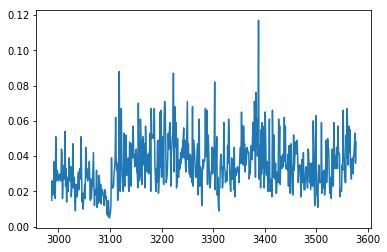

In [19]:
train_df['f'] = train_df['TransactionID'] // 1000
tmp = train_df[['f',label_name]].groupby(['f']).mean().reset_index()
plt.plot(tmp['f'],tmp[label_name])

In [20]:
tmp.loc[(tmp['f']>3350)&(tmp['f']<3400)]

,f,isFraud
364,3351,0.035
365,3352,0.041
366,3353,0.045
367,3354,0.036
368,3355,0.065
369,3356,0.037
370,3357,0.057
371,3358,0.035
372,3359,0.057
373,3360,0.045


In [16]:
test_df['TransactionID'].max()-test_df['TransactionID'].min()

506690

In [71]:
info_df.to_csv('%s/data/info.csv'%root,index=False)

In [11]:
train_df['id_03'].nunique()

24

In [85]:
def Get_card_id(df):
    card_info = ['card%s'%(i+1) for i in range(6)]
    #card_info.extend(['TransactionAmt','ProductCD'])
    tmp = df[card_info]
    for col in tmp.columns:
        tmp[col] = tmp[col].astype(str).apply(lambda x:x.replace('.0',''))
    tmp['card'] = tmp[card_info].apply(lambda x:'_'.join(x),axis=1)
    return tmp

In [71]:
tmp1 = Get_card_id(test_df)

In [86]:
tmp = Get_card_id(train_df)
tmp

,card1,card2,card3,card4,card5,card6,card
0,13926,nan,150,discover,142,credit,13926_nan_150_discover_142_credit
1,2755,404,150,mastercard,102,credit,2755_404_150_mastercard_102_credit
2,4663,490,150,visa,166,debit,4663_490_150_visa_166_debit
3,18132,567,150,mastercard,117,debit,18132_567_150_mastercard_117_debit
4,4497,514,150,mastercard,102,credit,4497_514_150_mastercard_102_credit
5,5937,555,150,visa,226,debit,5937_555_150_visa_226_debit
6,12308,360,150,visa,166,debit,12308_360_150_visa_166_debit
7,12695,490,150,visa,226,debit,12695_490_150_visa_226_debit
8,2803,100,150,visa,226,debit,2803_100_150_visa_226_debit
9,17399,111,150,mastercard,224,debit,17399_111_150_mastercard_224_debit


In [88]:
tmp['card'].nunique()

14893

In [90]:
tmp[label_name] = train_df[label_name]

In [103]:
df = tmp.groupby(['card']).agg({label_name:['count','mean']}).sort_values(by=[(label_name,'count')],ascending=False)
df.loc[(df[('isFraud','count')]==1)]

isFraud     
                                            count mean
card                                                  
9998_nan_nan_nan_nan_nan                        1  0.0
6477_555_213_visa_138_debit                     1  0.0
8982_390_150_mastercard_224_debit               1  0.0
9001_555_146_mastercard_166_debit               1  0.0
9002_nan_nan_nan_nan_nan                        1  0.0
10367_390_150_mastercard_195_debit              1  0.0
6707_nan_nan_nan_nan_nan                        1  0.0
6760_399_150_american express_104_credit        1  0.0
9123_555_150_visa_226_credit                    1  0.0
9173_555_150_visa_195_debit                     1  0.0
10003_nan_nan_nan_nan_nan                       1  0.0
6478_239_150_mastercard_195_debit               1  0.0
6711_555_150_visa_226_credit                    1  0.0
6759_555_150_visa_226_debit                     1  0.0
10187_399_150_american express_133_credit       1  0.0
8602_555_150_visa_226_credit                    1  0.0
10218_555_150_visa_138_debit                    1  0.0
8515_285_150_visa_226_debit                     1  0.0
10226_517_150_mastercard_224_debit              1  0.0
6712_nan_nan_nan_nan_nan                        1  0.0
8521_360_150_mastercard_166_debit               1  0.0
8230_399_150_american express_146_credit        1  0.0
8166_490_150_visa_226_debit                     1  0.0
6506_555_150_visa_226_debit                     1  0.0
9174_276_150_visa_194_credit                    1  1.0
8556_nan_nan_nan_nan_nan                        1  0.0
8168_480_150_mastercard_117_debit               1  0.0
8193_111_150_mastercard_224_credit              1  0.0
9997_527_150_visa_226_debit                     1  0.0
8979_555_150_visa_226_credit                    1  0.0
...                                           ...  ...
3018_555_144_visa_166_debit                     1  0.0
3015_555_107_visa_162_credit                    1  0.0
3014_399_150_american express_223_credit        1  0.0
3006_399_150_american express_223_credit        1  0.0
11497_302_150_visa_226_debit                    1  0.0
2998_555_150_visa_226_credit                    1  0.0
3072_555_146_visa_137_credit                    1  0.0
3072_nan_146_visa_137_credit                    1  0.0
3073_224_106_mastercard_224_credit              1  0.0
11485_555_120_visa_nan_credit                   1  0.0
3163_399_150_american express_223_credit        1  0.0
3155_555_150_visa_226_debit                     1  0.0
11474_555_150_visa_226_debit                    1  0.0
3153_555_102_visa_226_credit                    1  0.0
3151_443_150_mastercard_224_debit               1  0.0
3141_480_150_mastercard_224_debit               1  0.0
3139_555_150_visa_226_credit                    1  0.0
3138_555_162_mastercard_190_credit              1  1.0
3131_555_150_visa_226_debit                     1  0.0
11476_nan_144_visa_195_debit                    1  1.0
3128_390_150_mastercard_224_debit               1  0.0
3116_442_150_visa_226_credit                    1  0.0
3114_225_150_mastercard_195_debit               1  0.0
3110_512_150_mastercard_195_debit               1  0.0
3106_378_149_mastercard_224_debit               1  0.0
11478_555_150_visa_226_credit                   1  0.0
3099_480_150_mastercard_224_debit               1  0.0
11482_nan_nan_nan_nan_nan                       1  0.0
3092_555_150_visa_195_debit                     1  0.0
10000_111_150_mastercard_117_debit              1  0.0

[4103 rows x 2 columns]

In [108]:
99999999/3600/24

1157.4073958333333

In [102]:
train_df.loc[(tmp['card']=='2737_225_150_mastercard_166_debit'),train_df.columns[:17]]

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain
447233,3434233,1,11390276,337.45,W,2737,225.0,150.0,mastercard,166.0,debit,110.0,87.0,NaN,NaN,yahoo.com,NaN


In [112]:
np.roll(train_df.loc[(tmp['card']=='5812_408_185_mastercard_224_debit'),'TransactionDT'].diff(),-1)

array([1759., 1643.,  163., ...,  693., 2821.,   nan])

In [72]:
test_df.loc[(tmp1['card']=='9500_321_150_visa_226_debit_59_W'),test_df.columns[:15]]

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain
115,3663664,18405989,59.0,W,9500,321.0,150.0,visa,226.0,debit,204.0,87.0,NaN,NaN,gmail.com
149,3663698,18406862,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,NaN,NaN,gmail.com
203,3663752,18409256,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,2.0,NaN,NaN
1358,3664907,18471867,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,11.0,NaN,yahoo.com
1427,3664976,18473350,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,yahoo.com
1874,3665423,18482001,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,gmail.com
1946,3665495,18483619,59.0,W,9500,321.0,150.0,visa,226.0,debit,433.0,87.0,0.0,NaN,NaN
2070,3665619,18486230,59.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,1.0,NaN,NaN
2365,3665914,18492145,59.0,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,60.0,NaN,gmail.com
2430,3665979,18493731,59.0,W,9500,321.0,150.0,visa,226.0,debit,330.0,87.0,NaN,NaN,gmail.com


In [74]:
train_df[['id_%s'%str(i+1).zfill(2) for i in range(38)]].head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T
